## Importing Libraries

In [ ]:
from ucimlrepo import fetch_ucirepo

# Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings
warnings.filterwarnings('ignore')

# Sentiment Analysis
from transformers import pipeline


# LDA



import os
import nltk
import re
import string
import gensim
import numpy as np
from gensim.models import Phrases

import warnings
warnings.filterwarnings('ignore')

# for tokenization
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('wordnet')

# for stopword removal
from nltk.corpus import stopwords
nltk.download('stopwords')

# for lemmatization and POS tagging
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
import spacy

# for LDA
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

# for LDA evaluation
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvisualize



## Getting the Scraped Drug Review Dataset from UCI ML

In [23]:

# fetch dataset
drug_reviews_drugs_com = fetch_ucirepo(id=462)

# data (as pandas dataframes)
X = drug_reviews_drugs_com.data.features
y = drug_reviews_drugs_com.data.targets

# metadata
print(drug_reviews_drugs_com.metadata)


{'uci_id': 462, 'name': 'Drug Reviews (Drugs.com)', 'repository_url': 'https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com', 'data_url': 'https://archive.ics.uci.edu/static/public/462/data.csv', 'abstract': 'The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction.', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Text'], 'num_instances': 215063, 'num_features': 6, 'feature_types': ['Integer'], 'demographics': [], 'target_col': None, 'index_col': ['id'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C5SK5S', 'creators': ['Surya Kallumadi', 'Felix Grer'], 'intro_paper': {'title': 'Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning', 'authors': 'F. Grä

In [24]:
# Renaming for personal reference
df=X[X['condition']=='Birth Control']

## Exploratory Data Analysis

In [25]:
# Check dimensions
df.shape

(38436, 6)

In [26]:
# First five rows
df.head()

,drugName,condition,review,rating,date,usefulCount
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10
22,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,11-Aug-14,11


In [27]:
# Convert date to datetime
df['date']=pd.to_datetime(df.date)

In [28]:
# Check if the date is in datetime
df.head()

,drugName,condition,review,rating,date,usefulCount
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,2014-08-07,10
22,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,2014-08-11,11


In [29]:
# View one review
df['review'].iloc[1]


'"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"'

In [30]:
# View the last five rows
df.tail()

,drugName,condition,review,rating,date,usefulCount
215017,Etonogestrel,Birth Control,"""So I got Nexplanon just under a year ago. I o...",9,2013-11-05,3
215038,Levonorgestrel,Birth Control,"""I first would like to thank all of you that p...",3,2010-01-20,140
215056,Microgestin Fe 1 / 20,Birth Control,"""I was on Microgestin for about 3 years. Over ...",6,2014-08-01,15
215057,Apri,Birth Control,"""I started taking Apri about 7 months ago. My ...",9,2010-08-25,18
215060,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,2010-11-15,7


In [31]:
# Check Descriptive Statistics of the numerical columns
df.describe().T

,count,mean,min,25%,50%,75%,max,std
rating,38436.0,6.077974,1.0,3.0,7.0,9.0,10.0,3.309582
date,38436,2015-02-07 04:47:41.567280640,2008-02-27 00:00:00,2013-09-16 00:00:00,2015-11-07 00:00:00,2016-10-22 00:00:00,2017-12-12 00:00:00,NaN
usefulCount,38436.0,7.848944,0.0,2.0,5.0,9.0,1247.0,17.682386


In [32]:
# The distinct count of drugs
df.drugName.nunique()

181

In [33]:
# The distribution of the drugs
df.drugName.value_counts()

drugName
Etonogestrel                          4394
Ethinyl estradiol / norethindrone     3081
Levonorgestrel                        2884
Nexplanon                             2883
Ethinyl estradiol / levonorgestrel    2107
                                      ... 
Norlyda                                  1
Larin 24 Fe                              1
Loestrin 21 1.5 / 30                     1
Lillow                                   1
Cyclafem 7 / 7 / 7                       1
Name: count, Length: 181, dtype: int64

## Subsetting Data for Analysis
- Focused on top five most reviewed birth control drugs


In [34]:

drug_counts = df['drugName'].value_counts()
top_drugs = drug_counts.head(5).index

#Subset the DataFrame to include only the top 5 drugs
df = df[df['drugName'].isin(top_drugs)]

In [35]:
# New number of unique drugs
df.drugName.nunique()

5

### Distribution of the top 5 drugs

In [36]:
df.drugName.value_counts()

drugName
Etonogestrel                          4394
Ethinyl estradiol / norethindrone     3081
Levonorgestrel                        2884
Nexplanon                             2883
Ethinyl estradiol / levonorgestrel    2107
Name: count, dtype: int64

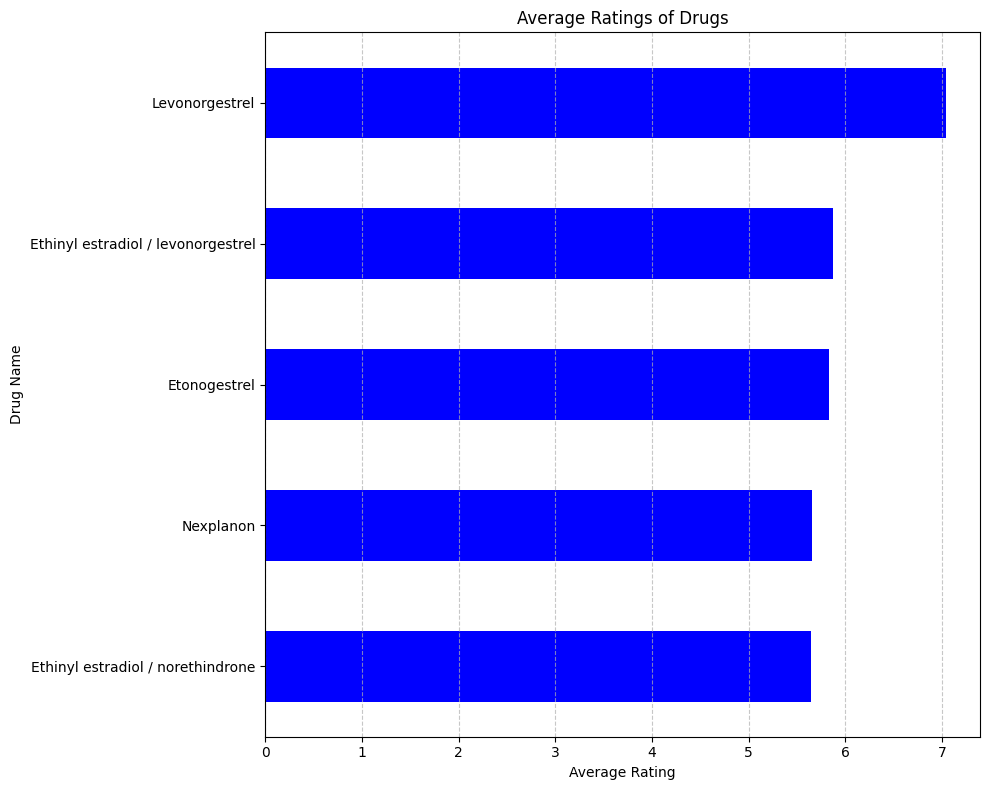

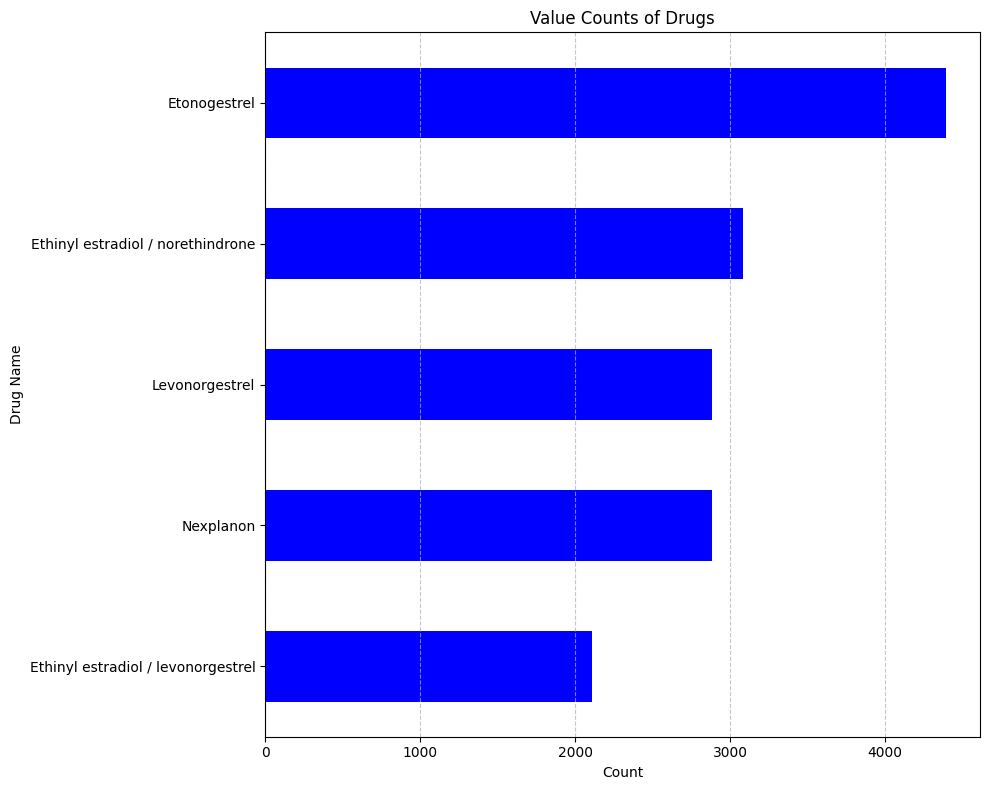

In [37]:
# Group by drug name and calculate the mean rating
mean_ratings = df.groupby('drugName')['rating'].mean()

# Plot the mean ratings
plt.figure(figsize=(10, 8))
mean_ratings.sort_values().plot(kind='barh', color='blue')
plt.title('Average Ratings of Drugs')
plt.xlabel('Average Rating')
plt.ylabel('Drug Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Group by drug name and get value counts
value_counts = df['drugName'].value_counts()

# Plot the value counts
plt.figure(figsize=(10, 8))
value_counts.sort_values().plot(kind='barh', color='blue')
plt.title('Value Counts of Drugs')
plt.xlabel('Count')
plt.ylabel('Drug Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Sentiment Analysis With Fine-Tuned DistilBert

### Text Preprocessing
- No extensive steps were taken since the transformers pipeline was used, which automatically handles tokenization and other preprocessing steps.

In [ ]:
# Function to clean text
def clean_text(text):
    # Remove HTML entities like '&#039 found in most of the reviews;'
    text = re.sub(r'&#\d+;', '', text)  # Remove HTML numeric character references
    return text

In [ ]:
# Applying the function to the review column
df['review'] = df['review'].apply(clean_text)

In [ ]:
# View the cleaned review
df['review'].iloc[0]

'"I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. Im also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesnt push me over the edge, as I believe I am depressed. Hopefully itll be just like when I was younger."'

### Sentiment Analysis Pipeline
- Each review was processed using the distilbert-base-uncased-finetuned-sst-2-english pipeline to predict sentiment. Confidence scores were also obtained to ascertain the predictions.

In [ ]:
# Load the pre-trained sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analysis = pipeline("sentiment-analysis", model=model_name, truncation=True)

# Define a function to get sentiment and confidence scores
def analyze_sentiment(text):
    result = sentiment_analysis(text)[0]
    sentiment = result['label']
    confidence = result['score']
    return pd.Series([sentiment, confidence], index=['sentiment', 'confidence'])


# Apply the sentiment analysis function to the reviews column
df[['sentiment', 'confidence']] = df['review'].apply(analyze_sentiment)

# Print the DataFrame with new columns
df.sample(10)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

,drugName,condition,review,rating,date,usefulCount,sentiment,confidence
108166,Etonogestrel,Birth Control,"""I had no issues after insertion at six weeks ...",5,2015-12-24,1,NEGATIVE,0.973629
160800,Nexplanon,Birth Control,"""I had the original impalanon in for three yea...",1,2016-03-23,3,NEGATIVE,0.999488
212792,Ethinyl estradiol / norethindrone,Birth Control,"""Ive been on this pill for about 6 months and ...",2,2015-12-21,4,NEGATIVE,0.990531
98158,Nexplanon,Birth Control,"""I had Nexplanon inserted a week ago, it was p...",10,2014-04-29,7,POSITIVE,0.949550
213265,Etonogestrel,Birth Control,"""I had implanon inserted a few months ago due ...",10,2017-11-06,4,NEGATIVE,0.970334
7716,Etonogestrel,Birth Control,"""I got nexplanon on Nov 11,2014 mostly because...",8,2016-07-01,3,NEGATIVE,0.989419
5487,Levonorgestrel,Birth Control,"""After several failed attempts by two differen...",5,2016-11-22,0,NEGATIVE,0.949211
94972,Nexplanon,Birth Control,"""I was on nexplanon for a year. Let me just sa...",1,2017-04-24,7,NEGATIVE,0.999303
89063,Nexplanon,Birth Control,"""Ive had this in for a few months and I love i...",8,2017-01-11,5,POSITIVE,0.999134
187909,Levonorgestrel,Birth Control,"""I am 19, and the obgyn I go to strongly sugge...",10,2014-03-20,32,POSITIVE,0.974640


In [ ]:
# save the data
df.to_csv('drug_reviews.csv', index=False)

## LDA Topic Modeling

### Text Preprocessing
1. Loaded the `en_core_web_sm` SpaCy model for NLP tasks.
2. Converted text to lowercase for uniformity.
3. Removed multiple white spaces and line breaks to clean the text.
4. Tokenized the text into individual words using NLTK's `word_tokenize`.
5. Removed non-alphabetic tokens to keep only words.
6. Used NLTK's stopword list and added custom stopwords specific to the context.
7. Removed these stopwords from the tokenized text.
8. Created bigrams and trigrams using Gensim's `Phrases` and `Phraser`.
9. Lemmatized the text using SpaCy, retaining only nouns, adjectives, verbs, and adverbs.
10. Applied the defined preprocessing pipeline to the DataFrame's `review` column.
11. Printed the first few processed reviews to verify the preprocessing steps.



In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define preprocessing pipeline
def txt_preprocess_pipeline(text):
    # Standardize text to lowercase
    standard_txt = text.lower()
    # Remove multiple white spaces and line breaks
    clean_txt = re.sub(r'\n', ' ', standard_txt)
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    clean_txt = clean_txt.strip()
    # Tokenize text
    tokens = word_tokenize(clean_txt)
    # Remove non-alphabetic tokens
    filtered_tokens_alpha = [word for word in tokens if word.isalpha()]
    # Load NLTK stopword list and add custom stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['rx', 'pill', 'use', 'nexplanon', 'pregnancy', 'nexplon', 'birth control','swing'])
    # Remove stopwords
    filtered_tokens_final = [w for w in filtered_tokens_alpha if not w in stop_words]

    # Create bigrams and trigrams
    bigrams = Phrases([filtered_tokens_final], min_count=1, threshold=100)
    bigram_mod = Phraser(bigrams)
    bigram_tokens = bigram_mod[filtered_tokens_final]

    trigrams = Phrases([bigram_tokens], threshold=100)
    trigram_mod = Phraser(trigrams)
    trigram_tokens = trigram_mod[bigram_tokens]

    # Lemmatization using SpaCy, keeping only noun, adj, vb, adv
    doc = nlp(' '.join(trigram_tokens))
    lemma_tokens = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]

    return lemma_tokens

# Apply the preprocessing pipeline to the DataFrame
df['processed_reviews'] = df['review'].apply(txt_preprocess_pipeline)

# Check the processed reviews
print(df['processed_reviews'].head())


9     [many, year, doctor, change, chateal, effectiv...
14    [start, month, ago, minimal, amount, contracep...
22    [job, worry, free, sex, thing, period, sometim...
74    [experience, great, yet, issue, cause, much, b...
75    [ve, mine, year, noticed, weight, gain, mood, ...
Name: processed_reviews, dtype: object


In [ ]:
# print first lemmatized instance
print(df['processed_reviews'].iloc[0])

['many', 'year', 'doctor', 'change', 'chateal', 'effective', 'really', 'help', 'completely', 'clear', 'acne', 'take', 'month', 'though', 'gain', 'extra', 'weight', 'develop', 'emotional', 'health', 'issue', 'stop', 'take', 'start', 'use', 'natural', 'method', 'birth', 'control', 'start', 'take', 'come', 'back', 'age', 'really', 'hope', 'symptom', 'depression', 'weight', 'gain', 'begin', 'affect', 'old', 'm', 'also', 'naturally', 'worsen', 'thing', 'negative', 'mental', 'rut', 'today', 'also', 'hope', 'push', 'edge', 'believe', 'depressed', 'hopefully', 'like', 'young']


In [ ]:
# First five rows
df.head()

,drugName,condition,review,rating,date,usefulCount,sentiment,confidence,processed_reviews
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,NEGATIVE,0.953042,"[many, year, doctor, change, chateal, effectiv..."
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,2014-08-07,10,NEGATIVE,0.999347,"[start, month, ago, minimal, amount, contracep..."
22,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,2014-08-11,11,NEGATIVE,0.997134,"[job, worry, free, sex, thing, period, sometim..."
74,Etonogestrel,Birth Control,"""My experience during the nexplon is great not...",10,2016-05-27,1,NEGATIVE,0.999737,"[experience, great, yet, issue, cause, much, b..."
75,Nexplanon,Birth Control,"""Ive had mine for over a year and noticed the ...",6,2016-06-19,1,POSITIVE,0.802087,"[ve, mine, year, noticed, weight, gain, mood, ..."


#### Additional Preprocessing Steps

- Created a dictionary (`id2word`) from the processed reviews using Gensim's `Dictionary` function. Filtered extremes to remove words that appear in less than 50 documents or more than 50% of the documents.

- Used the processed reviews to create the corpus (`texts`).

- Converted the processed reviews into a bag-of-words format (`corpus`) where each document is represented as a list of tuples with the word ID and its frequency in the document.


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df['processed_reviews'])
id2word.filter_extremes(no_below=50, no_above=0.5)

# Create Corpus
texts = df['processed_reviews']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# First five rows
df.head()

,drugName,condition,review,rating,date,usefulCount,sentiment,confidence,processed_reviews
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,NEGATIVE,0.953042,"[many, year, doctor, change, chateal, effectiv..."
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,2014-08-07,10,NEGATIVE,0.999347,"[start, month, ago, minimal, amount, contracep..."
22,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,2014-08-11,11,NEGATIVE,0.997134,"[job, worry, free, sex, thing, period, sometim..."
74,Etonogestrel,Birth Control,"""My experience during the nexplon is great not...",10,2016-05-27,1,NEGATIVE,0.999737,"[experience, great, yet, issue, cause, much, b..."
75,Nexplanon,Birth Control,"""Ive had mine for over a year and noticed the ...",6,2016-06-19,1,POSITIVE,0.802087,"[ve, mine, year, noticed, weight, gain, mood, ..."


## LDA Model No of Topics Selection
- The number of topics was selected based on coherence and perplexity scores. Three topics were chosen as they provided the highest coherence score. Although the perplexity was high, three topics were selected because they made the most sense after manually reviewing the representative documents in each topic.


In [ ]:
def compute_coherence_perplexity(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

# Define limit, start, and step
limit = 8
start = 2
step = 1

# Compute coherence and perplexity values for different numbers of topics
model_list, coherence_values, perplexity_values = compute_coherence_perplexity(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)


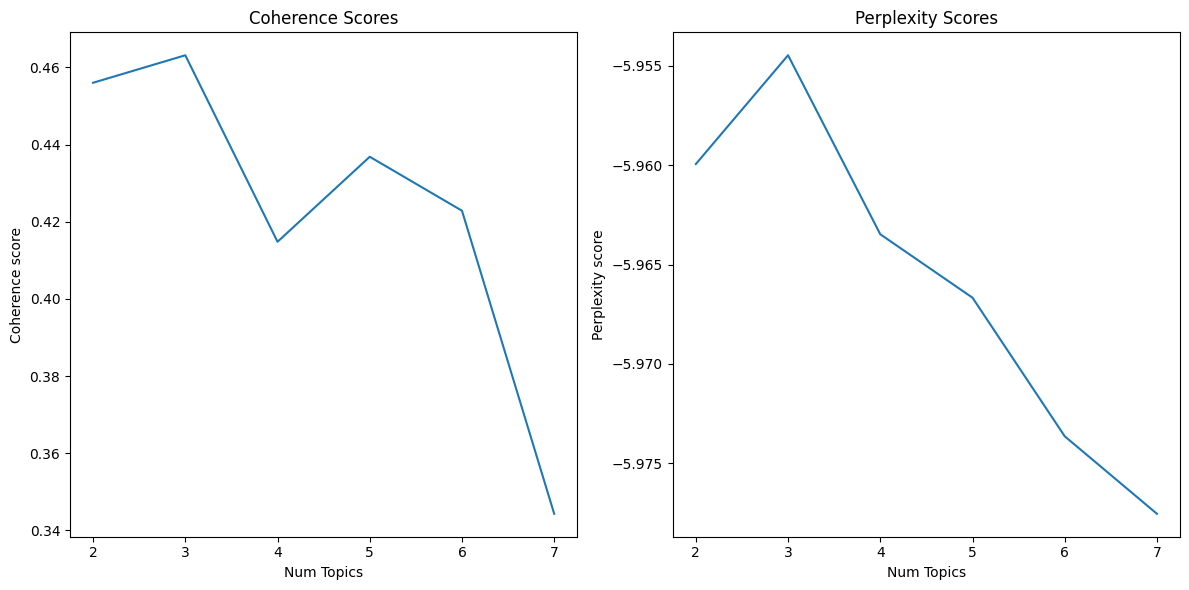

In [ ]:
# Plot coherence score
x = range(start, limit, step)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores")

# Plot perplexity score
plt.subplot(1, 2, 2)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.title("Perplexity Scores")

plt.tight_layout()
plt.show()


In [ ]:
# Select the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))


[(0, '0.030*"year" + 0.026*"control" + 0.026*"birth" + 0.025*"gain" + 0.025*"weight" + 0.020*"first" + 0.018*"take" + 0.018*"side" + 0.017*"effect" + 0.015*"mood"'), (1, '0.044*"week" + 0.034*"day" + 0.031*"go" + 0.024*"start" + 0.023*"bleed" + 0.023*"bad" + 0.021*"feel" + 0.020*"time" + 0.018*"stop" + 0.016*"implant"'), (2, '0.070*"cramp" + 0.048*"pain" + 0.040*"insertion" + 0.035*"insert" + 0.028*"mirena" + 0.028*"painful" + 0.027*"day" + 0.021*"feel" + 0.016*"bad" + 0.016*"hurt"')]


## Topics Visualization

In [ ]:
# Prepare the pyLDAvis visualization
pyLDAvis.enable_notebook()

# Generate the visualization
lda_display = gensimvis.prepare(optimal_model, corpus, id2word, sort_topics=False)

# Display the visualization in a Jupyter Notebook
pyLDAvis.display(lda_display)



## Topic Assignment
- Each observation was assigned its most dominant topic.
- Themes were inferred from the three topics, namely: "Weight Gain and Side Effects," "Bleeding and Cycle Issues," and "Pain and Insertion Issues."


In [ ]:
def get_dominant_topic(corpus, lda_model):
    dominant_topics = []
    for doc_bow in corpus:
        # Get topic probabilities for the document
        topic_probs = lda_model.get_document_topics(doc_bow)
        # Check if topic_probs is not empty
        if topic_probs:
            # Sort probabilities and get the topic index with highest probability
            sorted_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
            dominant_topic = sorted_probs[0][0]  # Topic ID with the highest probability
        else:
            dominant_topic = -1  # No topic assigned if topic_probs is empty
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign topics to each review
df['Topic'] = get_dominant_topic(corpus, optimal_model)

# Check the DataFrame with the new column
df.head()

,drugName,condition,review,rating,date,usefulCount,sentiment,confidence,processed_reviews,Topic
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,NEGATIVE,0.953042,"[many, year, doctor, change, chateal, effectiv...",0
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,2014-08-07,10,NEGATIVE,0.999347,"[start, month, ago, minimal, amount, contracep...",0
22,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,2014-08-11,11,NEGATIVE,0.997134,"[job, worry, free, sex, thing, period, sometim...",0
74,Etonogestrel,Birth Control,"""My experience during the nexplon is great not...",10,2016-05-27,1,NEGATIVE,0.999737,"[experience, great, yet, issue, cause, much, b...",1
75,Nexplanon,Birth Control,"""Ive had mine for over a year and noticed the ...",6,2016-06-19,1,POSITIVE,0.802087,"[ve, mine, year, noticed, weight, gain, mood, ...",0


In [ ]:
# Define the mapping from topic IDs to descriptive names
topic_names = {
    0: "Weight Gain and Side Effects",
    1: "Bleeding and Cycle Issues",
    2: "Pain and Insertion Issues"
}

# Apply the mapping using a lambda function
df['Topic_Name'] = df['Topic'].apply(lambda x: topic_names[x] if x in topic_names else None)

# Drop the old 'Topic' column if you don't need it
df = df.drop(columns=['Topic'])

# Check the DataFrame with the new column
df.head()


,drugName,condition,review,rating,date,usefulCount,sentiment,confidence,processed_reviews,Topic_Name
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,NEGATIVE,0.953042,"[many, year, doctor, change, chateal, effectiv...",Weight Gain and Side Effects
14,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,2014-08-07,10,NEGATIVE,0.999347,"[start, month, ago, minimal, amount, contracep...",Weight Gain and Side Effects
22,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,2014-08-11,11,NEGATIVE,0.997134,"[job, worry, free, sex, thing, period, sometim...",Weight Gain and Side Effects
74,Etonogestrel,Birth Control,"""My experience during the nexplon is great not...",10,2016-05-27,1,NEGATIVE,0.999737,"[experience, great, yet, issue, cause, much, b...",Bleeding and Cycle Issues
75,Nexplanon,Birth Control,"""Ive had mine for over a year and noticed the ...",6,2016-06-19,1,POSITIVE,0.802087,"[ve, mine, year, noticed, weight, gain, mood, ...",Weight Gain and Side Effects


In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('drug_reviews_with_topics.csv', index=False)